In [1]:
# !pip install nvidia-cudnn-cu11==8.6.0.163 tensorflow==2.13.*

In [2]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# import keras
import numpy as np

import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import random

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# from tensorflow.compat.v1 import ConfigProto, InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [4]:
# conect drive files with the colab
# https://www.tensorflow.org/tutorials/load_data/images
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Caminho para o diretório principal do dataset
# dataset_dir = 'drive/MyDrive/dataset/diabetic rinopaty/test' # drive directory

# train_dir = 'E:\\documentos\\tcc\dataset1\\train' # local directory
train_dir = 'E:\\retinopatia-dataset\\train' # local directory
# test_dir = 'E:\\documentos\\tcc\dataset1\\test' # local directory

labels_file = 'E:\\retinopatia-dataset\\trainLabels.csv'
# labels_df = pd.read_csv(labels_file)
# labels_df['level'] = labels_df['level'].astype(str)

# train_dir = 'E:\\retinopatia-resized\\resized_train_cropped\\equalized_pb' # local directory

# labels_file = "E:\\retinopatia-resized\\trainLabels_equalized.csv"
labels_df = pd.read_csv(labels_file)
labels_df['level'] = labels_df['level'].astype(str)


In [6]:
print(np.count_nonzero(labels_df['level'] == '0'))
print(np.count_nonzero(labels_df['level'] == '1'))
print(np.count_nonzero(labels_df['level'] == '2'))
print(np.count_nonzero(labels_df['level'] == '3'))
print(np.count_nonzero(labels_df['level'] == '4'))
print("-"*10)
print(np.count_nonzero(labels_df['image']))

25801
2437
5288
872
708
----------
35106


In [4]:
def get_quantity_by_class(y_set):
    # Use a função unique do NumPy para obter os rótulos únicos e suas contagens
    classes, counts = np.unique(y_set, return_counts=True)

    # Crie um dicionário para mapear rótulos de classe para contagens
    class_counts = dict(zip(classes, counts))

    return class_counts

In [5]:
def new_augmentate(X_train, y_train, target_size, INPUT_SHAPE, BATCH_SIZE):
    # Separe os exemplos em grupos com base nas classes
    x_train_augment = []
    y_train_augment = []

    quantities = get_quantity_by_class(y_train)
    classes_target = [-target_size if x > target_size else target_size//x for x in quantities.values()]

    i = 0
    while True:
        if i >= len(y_train):
            break

        pos = int(y_train[i][0])

        if classes_target[pos] < 0:
            classes_target[pos] += 1

        elif classes_target[pos] > 0:
            for j in range(classes_target[pos]):
                x_train_augment.append(X_train[i])
                y_train_augment.append(y_train[i])

        else:
            X_train = X_train[0:i] + X_train[i+1:]
            y_train = y_train[0:i] + y_train[i+1:]
            i -= 1

        i += 1

    X_train = X_train + x_train_augment
    y_train = y_train + y_train_augment

    datagen = ImageDataGenerator(
            rescale=1.0/255.0,  # Rescale pixel values to the range [0, 1]
            rotation_range=270,
            horizontal_flip=True,
    )

    return X_train, y_train, datagen.flow_from_dataframe(
            pd.DataFrame({'image': X_train, 'level': y_train}),
            directory='.',  # O diretório base das imagens
            x_col='image',
            y_col='level',
            target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=True
        )

In [6]:

def show_data_quantity(y_set):
    # Use a função unique do NumPy para obter os rótulos únicos e suas contagens
    classes, counts = np.unique(y_set, return_counts=True)

    # Crie um dicionário para mapear rótulos de classe para contagens
    class_counts = dict(zip(classes, counts))

    # Exiba as contagens de cada classe
    for classe, count in class_counts.items():
        print(f"Classe {classe}: {count} amostras")
# from imblearn.over_sampling import SMOTE

# Define your hyperparameters
INPUT_SHAPE = (256, 256, 3)
NUM_CLASSES = 5
EPOCHS = 20
BATCH_SIZE = 32

# monta caminho das imagens
image_file_paths = [os.path.join(train_dir, filename + '.jpeg') for filename in labels_df['image']]
labels = labels_df['level']

data = list(zip(image_file_paths, labels))
random.shuffle(data)
image_file_paths, labels = zip(*data)

# Divida o conjunto em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(image_file_paths, labels, test_size=0.2, random_state=42)

# print("QUANTITY")
# show_data_quantity(y_train)
# Divida o conjunto de treinamento em treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Rescale pixel values to the range [0, 1]
)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

X_train, y_train, train_generator = new_augmentate(X_train, y_train, 3000, INPUT_SHAPE, BATCH_SIZE)
# print("AFTER ALGMENTATION")
# show_data_quantity(y_train)
# validation_generator = validation_datagen.flow_from_dataframe(
#     pd.DataFrame({'image': X_val, 'level': y_val}),
#     directory='.',  # O diretório base das imagens
#     x_col='image',
#     y_col='level',
#     target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
#     batch_size=BATCH_SIZE,
#     class_mode='categorical')
X_val, y_val, validation_generator = new_augmentate(X_val, y_val, 1000, INPUT_SHAPE, BATCH_SIZE)

test_generator = test_datagen.flow_from_dataframe(
    pd.DataFrame({'image': X_test, 'level': y_test}),
    directory='.',  # O diretório base das imagens
    x_col='image',
    y_col='level',
    target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
    batch_size=BATCH_SIZE,
    class_mode='categorical')  # Se for um problema de classificação

Found 15663 validated image filenames belonging to 5 classes.
Found 5887 validated image filenames belonging to 5 classes.
Found 7026 validated image filenames belonging to 5 classes.


In [68]:
def show_data_quantity(y_set):
    # Use a função unique do NumPy para obter os rótulos únicos e suas contagens
    classes, counts = np.unique(y_set, return_counts=True)

    # Crie um dicionário para mapear rótulos de classe para contagens
    class_counts = dict(zip(classes, counts))

    # Exiba as contagens de cada classe
    for classe, count in class_counts.items():
        print(f"Classe {classe}: {count} amostras")

print("treino")
show_data_quantity(y_train)
print("-"*30)
print("validação")
show_data_quantity(y_val)
print("-"*30)
print("teste")
show_data_quantity(y_test)

treino
Classe 0: 3000 amostras
Classe 1: 3006 amostras
Classe 2: 3000 amostras
Classe 3: 3426 amostras
Classe 4: 3150 amostras
------------------------------
validação
Classe 0: 1000 amostras
Classe 1: 1215 amostras
Classe 2: 1724 amostras
Classe 3: 1022 amostras
Classe 4: 1080 amostras
------------------------------
teste
Classe 0: 5126 amostras
Classe 1: 529 amostras
Classe 2: 1089 amostras
Classe 3: 155 amostras
Classe 4: 123 amostras


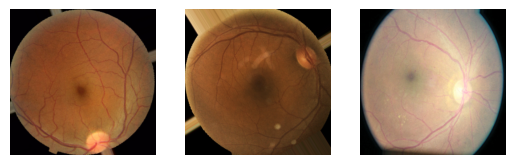

In [17]:
images, labels = next(train_generator)
image_to_plot = images[0]

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(image_to_plot, cmap="gray")
    plt.axis('off')

    images, labels = next(train_generator)
    image_to_plot = images[0]

plt.show()

In [12]:
def create_alexnet(input_shape, num_classes):
    # Definir a arquitetura da AlexNet
    model = models.Sequential()

    # Camada 1
    model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape)) # 96
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    # Camada 2
    model.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu')) #256
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    # Camada 3
    model.add(layers.Conv2D(96, (3, 3), padding='same', activation='relu')) # 348
    
    # Camada 4
    model.add(layers.Conv2D(96, (3, 3), padding='same', activation='relu')) # 384
    
    # Camada 5
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu')) # 256
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    # Camada 6 - Flatten
    model.add(layers.Flatten())
    
    # Camada 7 - Fully connected (Dense)
    model.add(layers.Dense(4096, activation='relu')) # 4096
    model.add(layers.Dropout(0.5))
    
    # Camada 8 - Fully connected (Dense)
    model.add(layers.Dense(2048, activation='relu')) # 4096
    model.add(layers.Dropout(0.5))
    
    # Camada de saída
    model.add(layers.Dense(num_classes, activation='softmax'))  # 1000 classes para o ImageNet
    
    model.summary()

    return model

In [13]:
def vgg16_model(input_shape=(256, 256, 3), num_classes=5):
    input_tensor = layers.Input(shape=input_shape)

    # Bloco 1
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_tensor)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Bloco 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(x) # 128
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(x) # 128
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Bloco 3
    # x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1')(x) # 256
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block3_conv2')(x) # 256
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block3_conv3')(x) # 256
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Bloco 4
    # x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv1')(x) # 512
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv2')(x) # 512
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv3')(x) # 512
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Bloco 5
    # x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block5_conv1')(x) # 512
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block5_conv2')(x) # 512
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block5_conv3')(x) # 512
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Camada totalmente conectada
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(4096, activation='relu', name='fc1')(x) # 4096
    x = layers.Dense(4096, activation='relu', name='fc2')(x) # 4096
    x = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = models.Model(inputs=input_tensor, outputs=x, name='vgg16')
    
    return model

In [14]:
def residual_block(x, filters, kernel_size=3, stride=1, weight_initializer='glorot_uniform'):
    shortcut = x
    # Primeira convolução
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same', kernel_initializer=weight_initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    # Segunda convolução
    x = layers.Conv2D(filters, kernel_size=kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    # Conexão residual
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride)(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet(input_shape, num_classes, num_blocks, num_filters, weight_initializer='glorot_uniform'):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(num_filters[0], kernel_size=7, strides=2, padding='same', kernel_initializer=weight_initializer)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.AveragePooling2D(pool_size=3, strides=2, padding='same')(x)

    for i in range(len(num_blocks)):
        for j in range(num_blocks[i]):
            stride = 1 if i == 0 and j == 0 else 2
            x = residual_block(x, num_filters[i], stride=stride, weight_initializer=weight_initializer)

    x = layers.AveragePooling2D(pool_size=3, strides=2, padding='same')(x)  # Atualizado para 256x256
    x = layers.Flatten()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=x)
    return model

def CustomResNet(input_shape, num_classes, num_blocks, num_filters):
    model = build_resnet(input_shape, num_classes, num_blocks, num_filters, weight_initializer='glorot_uniform')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])

In [15]:
def myModel(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (11, 11), strides=4, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2), strides=2))
    model.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=2))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=2))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=2))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=2))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.summary()

    return model

In [16]:
def CustomAlexNet(learning_rate=0.001, weight_initializer='glorot_uniform', dropout_rate=0.0):
    input_shape=INPUT_SHAPE
    num_classes=NUM_CLASSES

    model = models.Sequential()

    # Camada 1
    # model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), activation='relu', input_shape=input_shape, kernel_initializer=weight_initializer)) # 96
    # model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), activation='relu', input_shape=input_shape, kernel_initializer=weight_initializer)) # 96
    model.add(layers.Conv2D(32, (7, 7), activation='relu', input_shape=input_shape, kernel_initializer=weight_initializer)) # 96
    model.add(layers.Conv2D(32, (7, 7), activation='relu', input_shape=input_shape, kernel_initializer=weight_initializer)) # 96
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(3, 3)))
    
    # Camada 2
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer=weight_initializer)) #256
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer=weight_initializer)) #256
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(3, 3)))
    
    # Camada 3
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer=weight_initializer)) # 348
    # model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=weight_initializer)) # 348
    model.add(layers.BatchNormalization())
    
    # Camada 4
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer=weight_initializer)) # 384
    # model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=weight_initializer)) # 384
    model.add(layers.BatchNormalization())
    
    # Camada 5
    # model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=weight_initializer)) # 256
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer=weight_initializer)) # 256
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    # Camada 6 - Flatten
    model.add(layers.Flatten())
    
    # Camada 7 - Fully connected (Dense)
    model.add(layers.Dense(4096, activation='relu', kernel_initializer=weight_initializer)) # 4096
    model.add(layers.Dropout(dropout_rate))
    
    # Camada 8 - Fully connected (Dense)
    model.add(layers.Dense(4096, activation='relu', kernel_initializer=weight_initializer)) # 4096
    model.add(layers.Dropout(dropout_rate))
    
    # Camada de saída
    model.add(layers.Dense(num_classes, activation='softmax'))  # 1000 classes para o ImageNet
    # model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), #, momentum=momentum), # adam nao tem momentum
              loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [17]:
from sklearn.model_selection import GridSearchCV

def AlexNetGridSearch():
    param_grid = {
        'learning_rate': [0.001, 0.01, 0.1],
        # 'momentum': [0.5, 0.9, 0.99],
        'weight_initializer': ['glorot_uniform', 'he_normal'],
        'dropout_rate': [0.2, 0.4]
    }
    X, Y = train_generator.next()
    model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=CustomAlexNet, epochs=10, batch_size=BATCH_SIZE, verbose=1)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=3)
    return grid.fit(X, Y)#X_train, y_train)

# grid_result = AlexNetGridSearch()
# # Avalie os resultados
# print("Melhores hiperparâmetros encontrados:", grid_result.best_params_)
# print("Melhor precisão encontrada:", grid_result.best_score_)

In [18]:
def ResNetGridSearch():
    param_grid = {
        'num_filters': [[32, 64, 128, 128], [64, 64, 128, 128]],
        'num_blocks': [[3, 4, 6, 3], [3, 4, 4, 3], [3, 3, 3, 3]]
    }

    X, Y = train_generator.next()
    model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=CustomResNet, epochs=10, batch_size=BATCH_SIZE, verbose=0)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=3)
    return grid.fit(X, Y)#X_train, y_train)

# grid_result = ResNetGridSearch()

# print("Melhores hiperparâmetros encontrados:", grid_result.best_params_)
# print("Melhor precisão encontrada:", grid_result.best_score_)

In [31]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

model = None
with tf.device(device_name):
    # learning rate 10-4
    model = CustomAlexNet(0.00001, 'glorot_uniform', 0.2)
    # model = vgg16_model(INPUT_SHAPE, NUM_CLASSES)
    # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    #               loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

# history = None
custom_epoch = 20
# steps_per_epoch=10,
# steps_per_epoch=400,
while True:
    try:
        history = model.fit(
            train_generator,
            epochs=custom_epoch,
            validation_data=validation_generator,
            steps_per_epoch=400,
            validation_steps=400,
            batch_size=BATCH_SIZE)
        
        break
    except Exception as e:
        print(e)
        if custom_epoch > 10:
            custom_epoch -= 10
        else:
            break

Epoch 1/20
400/400 [==============================] - 1218s 3s/step - loss: 1.5523 - accuracy: 0.3190 - val_loss: 1.6437 - val_accuracy: 0.2705
Epoch 2/20
400/400 [==============================] - 1194s 3s/step - loss: 1.5619 - accuracy: 0.3055 - val_loss: 1.8330 - val_accuracy: 0.2265
Epoch 3/20
400/400 [==============================] - 1247s 3s/step - loss: 1.5543 - accuracy: 0.3185 - val_loss: 1.5273 - val_accuracy: 0.3005
Epoch 4/20
400/400 [==============================] - 1227s 3s/step - loss: 1.5337 - accuracy: 0.3155 - val_loss: 1.5685 - val_accuracy: 0.3025
Epoch 5/20
400/400 [==============================] - 1205s 3s/step - loss: 1.5015 - accuracy: 0.3440 - val_loss: 1.5618 - val_accuracy: 0.2970
Epoch 6/20
400/400 [==============================] - 1325s 3s/step - loss: 1.5321 - accuracy: 0.3320 - val_loss: 1.5833 - val_accuracy: 0.2950
Epoch 7/20
400/400 [==============================] - 1126s 3s/step - loss: 1.4929 - accuracy: 0.3390 - val_loss: 2.1244 - val_accuracy:

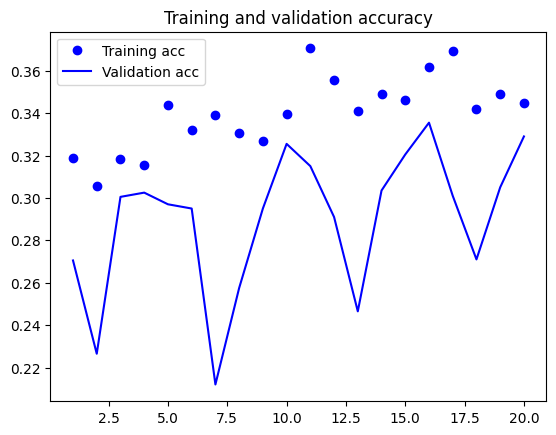

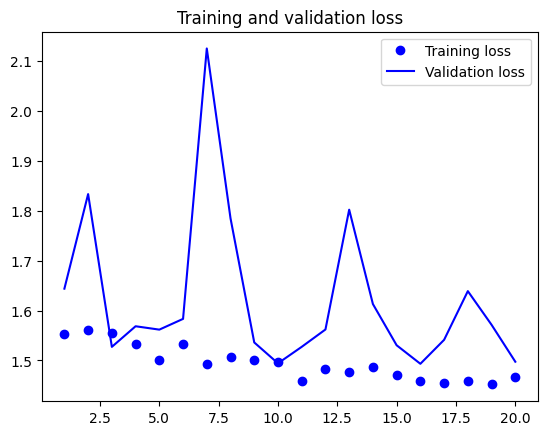

In [32]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_history(history)

In [7]:
model = models.load_model("E:\\documentos\\tcc\\cod\\modelos\\CustomAlex1\\CustomAlex-augmentation.h5")

In [8]:
def run_test(model):
    num_test_samples = len(test_generator)
    batch_size = test_generator.batch_size

    print(num_test_samples, batch_size)

    steps = num_test_samples // batch_size

    test_loss, test_accuracy = model.evaluate(test_generator, batch_size=batch_size)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')
    return test_loss, test_accuracy

test_loss, test_accuracy = run_test(model)

220 32
220/220 [==============================] - 657s 3s/step - loss: 1.4592 - accuracy: 0.2686
Test Loss: 1.4592063426971436
Test Accuracy: 0.2685738801956177


In [35]:
model.save('calex-small-kernel20(ultimo).h5')

In [9]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report

def predict_one_img(model):
    image_path2 = 'E:\\retinopatia-dataset\\train\\10_right.jpeg'
    image2 = load_img(image_path2, target_size=(256, 256))  # Ensure the target size matches your model's input size
    image2 = img_to_array(image2)
    image2 = np.expand_dims(image2, axis=0)

    predictions = model.predict(image2)

    print(predictions)
    print(np.argmax(predictions, axis=1))

predict_one_img(model)

[[2.7778081e-33 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]]
[2]


In [10]:

# Faça previsões no conjunto de teste
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

In [25]:
# print(y_pred)
print(len(y_pred))
print(len(y_test))

7022
7022


In [11]:
# print(y_pred)
# print(y_pred_classes)
print(len(y_pred), len(y_pred_classes))
print(np.count_nonzero(y_pred_classes == 0))
print(np.count_nonzero(y_pred_classes == 1))
print(np.count_nonzero(y_pred_classes == 2))
print(np.count_nonzero(y_pred_classes == 3))
print(np.count_nonzero(y_pred_classes == 4))

7026 7026
1483
427
5116
0
0


In [13]:
y_test = [int(x) for x in y_test]

# Imprima a acurácia
# print(f"Acurácia: {test_accuracy:.2f}")

# Imprima um relatório de classificação, que inclui precisão, recall, F1-score para cada classe
report = classification_report(y_test, y_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.21      0.33      5169
           1       0.08      0.07      0.08       508
           2       0.15      0.74      0.25      1044
           3       0.00      0.00      0.00       160
           4       0.00      0.00      0.00       145

    accuracy                           0.27      7026
   macro avg       0.19      0.20      0.13      7026
weighted avg       0.57      0.27      0.28      7026



e:\programas\anaconda3\envs\tcc\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\programas\anaconda3\envs\tcc\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\programas\anaconda3\envs\tcc\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
from sklearn.metrics import roc_auc_score, f1_score


# Calcule a Área Sob a Curva (AUC) da Curva ROC
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print(f"AUC da Curva ROC: {roc_auc:.2f}")

# Calcule o F1-score
y_pred_classes = np.argmax(y_pred, axis=1)
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f"F1-Score: {f1:.2f}")
f1 = f1_score(y_test, y_pred_classes, average='micro')
print(f"F1-Score (micro): {f1:.2f}")

AUC da Curva ROC: 0.51
F1-Score: 0.28
F1-Score (micro): 0.27


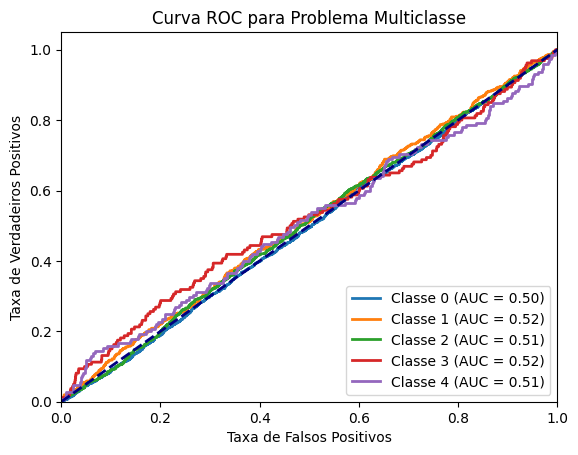

In [15]:
from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import label_binarize

# Transforme seus rótulos multiclasse em rótulos binários (one-hot encoding)
y_test_bin = label_binarize(y_test, classes=np.arange(NUM_CLASSES))

# Inicialize as listas para armazenar as taxas de falsos positivos, verdadeiros positivos e AUCs
fpr = []
tpr = []
roc_auc = []

# Para cada classe, calcule a curva ROC e a AUC
for i in range(NUM_CLASSES):
    fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc_i = auc(fpr_i, tpr_i)
    fpr.append(fpr_i)
    tpr.append(tpr_i)
    roc_auc.append(roc_auc_i)

# Plote as curvas ROC para cada classe
plt.figure()
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Classe {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC para Problema Multiclasse')
plt.legend(loc='lower right')
plt.show()